In [1]:
# Starter

__author__ = "Philipp Kats"
from datetime import date
__date__ = date.today().strftime('%Y-%m-%d')

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

import pandas as pd
import geopandas as gp
import os
import json
import SE
import altair as alt

from tqdm import tqdm, tqdm_notebook
tqdm().pandas()
#from hyperdash import monitor_cell, Experiment
 

from SE.areas import get_all_areas, get_larger_area
from SE.sql import _get_DF
from SE import definitions
#from SE.sql import queries
idx = pd.IndexSlice

print(__date__)
print(SE.__version__)

0it [00:00, ?it/s]

2018-09-10
5.8.5+118.ga0528d4


In [2]:
from SE.spatial import get_better_boundaries
nyc = get_better_boundaries(area_type='city')

In [3]:
cb = pd.read_pickle('../data/correct_geom.pkl')

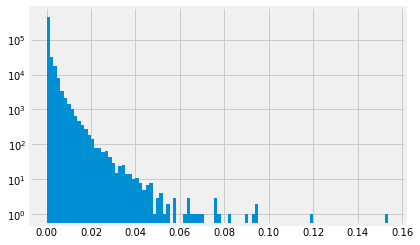

In [4]:
cb.area.hist(bins=100, log=True)

In [5]:
cb.area.max()

0.15380406110000103

In [6]:
cb_small = cb[cb.area <= 0.05]  ## Drop too large ones

In [13]:
cb_small.reset_index(drop=True, inplace=True)

In [17]:
cb_small['AREA'] = cb_small.area

/Users/philippk/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## bd visualisation

In [7]:
from rasterio import features, Affine, float64
from rasterio.enums import MergeAlg
from xarray import DataArray
import numpy as np

import datashader as ds
from datashader import transfer_functions as tf, reductions as rd
from datashader.colors import Hot, viridis

In [8]:
import colorcet
kbc = colorcet.cm.kbc

In [9]:
def get_transform(cvs):
    '''transform into canvas coordinates'''
    return Affine((cvs.x_range[1] - cvs.x_range[0]) / cvs.plot_width, 0.0,
                   cvs.x_range[0], 0.0, (cvs.y_range[0] - cvs.y_range[1]) / cvs.plot_height, cvs.y_range[1])

In [10]:
print(nyc['geometry'].iloc[0].envelope.buffer(.05).envelope)
## slightly offcet from NYC borders

POLYGON ((-74.30761 40.44423, -73.647738 40.44423, -73.647738 40.96624, -74.30761 40.96624, -74.30761 40.44423))


In [11]:
cvs = ds.Canvas(plot_height=1000,
                plot_width=1000,
                x_range=(-73.647738, -74.301),
                y_range=(40.45, 41.))

aform = get_transform(cvs)
aform

Affine(-0.000653261999999998, 0.0, -73.647738,
       0.0, -0.0005499999999999971, 41.0)

## AREAs Map

In [12]:
# boundaries = cb['geometry'].tolist()
boundaries = cb_small['geometry'].tolist()

In [18]:
from dask import bag as db

In [19]:
BAG = db.from_sequence(cb['geometry'].tolist(), npartitions=2)

In [25]:
def _rasterize_area(geom):
    return features.rasterize([(geom, geom.area)],  out_shape=(cvs.plot_height, cvs.plot_width), transform=aform, dtype=float64)
    

In [26]:
BAG2 = BAG.map(_rasterize_area)

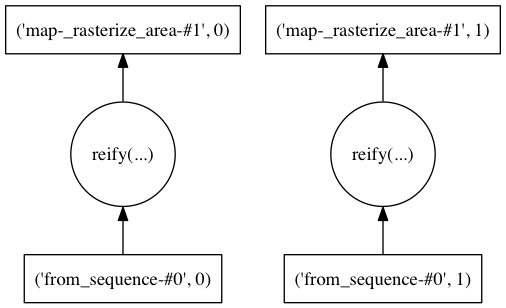

In [27]:
BAG2.visualize()

In [28]:
from dask.diagnostics import ProgressBar

In [ ]:
with ProgressBar():
    B = BAG2.compute()

[                                        ] | 0% Completed |  3min 40.4s